In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# sklearn stuff
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import TransformerMixin
from sklearn.datasets import make_regression

# model functionality and validation
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# regressor models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor


In [2]:
# data pipeline

# read in file
raw_data = pd.read_csv("AmesHousing.csv", "~")

# see what has been loaded
raw_data.keys()

# select most likely key features
data = raw_data[["SalePrice", "1st Flr SF", "2nd Flr SF", "MS Zoning", "Lot Frontage", "Lot Area", "Land Contour", "Bldg Type", "House Style", "Overall Qual", "Overall Cond", "Year Built", "Year Remod/Add", "Bsmt Qual", "Bsmt Cond", "Heating", "Central Air", "Full Bath", "Half Bath", "Bedroom AbvGr", "Fireplaces", "Garage Type", "Garage Cars", "Pool Area", "Pool QC", "Yr Sold"]]

# ensure we've loaded what we want
data.keys()

# convert to a simplified dataframe for initial work
simple_data = data[["SalePrice", "1st Flr SF", "2nd Flr SF", "Year Built", "Full Bath", "Half Bath", "Bedroom AbvGr", "Garage Cars", "Yr Sold"]]

# fill in nan for 2nd floor square feet with zeros, which makes sense
simple_data.loc[:, "2nd Flr SF"].fillna(0, inplace=True)

# calculate simple square footage
square_feet = simple_data.loc[:,"1st Flr SF"] + simple_data.loc[:,"2nd Flr SF"]

# add this to the data frame then clean up the data frame some
simple_data = pd.concat((simple_data, square_feet), axis=1)
simple_data.drop(0, axis=1, inplace=True)
simple_data.drop("1st Flr SF", axis=1, inplace=True)
simple_data.drop("2nd Flr SF", axis=1, inplace=True)

# fix nans
simple_data["Garage Cars"].fillna(0, inplace=True)

# get Y labels
Y = simple_data.loc[:,"SalePrice"]

simple_data.pop("SalePrice")
print simple_data.describe()

        Year Built    Full Bath    Half Bath  Bedroom AbvGr  Garage Cars  \
count  2930.000000  2930.000000  2930.000000    2930.000000  2930.000000   
mean   1971.356314     1.566553     0.379522       2.854266     1.766212   
std      30.245361     0.552941     0.502629       0.827731     0.761137   
min    1872.000000     0.000000     0.000000       0.000000     0.000000   
25%    1954.000000     1.000000     0.000000       2.000000     1.000000   
50%    1973.000000     2.000000     0.000000       3.000000     2.000000   
75%    2001.000000     2.000000     1.000000       3.000000     2.000000   
max    2010.000000     4.000000     2.000000       8.000000     5.000000   

           Yr Sold  
count  2930.000000  
mean   2007.790444  
std       1.316613  
min    2006.000000  
25%    2007.000000  
50%    2008.000000  
75%    2009.000000  
max    2010.000000  


/home/brian/anaconda2/lib/python2.7/site-packages/pandas/core/generic.py:3549: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [98]:
# split the data for train and test
X_train, X_test, y_train, y_test = train_test_split(simple_data.values, Y, test_size=0.20)

y_train = np.array(y_train).reshape(-1, 1)
y_test = np.array(y_test).reshape(-1, 1)

print "y_train", y_train.shape
print "X_train", X_train.shape
print "y_test", y_test.shape
print "X_test", X_test.shape

# subdivide again for 2 stage ensemble
X_train1, X_train2, y_train1, y_train2 = train_test_split(X_train, y_train, test_size=0.5)

y_train1 = y_train1.reshape(-1, 1)
y_train2 = y_train2.reshape(-1, 1)

def make_data_splits(X, Y):
    '''
    Take data in and split it into 3 sets for a 2 stage stacked ensemble
    return 3 X_set splits and 3 y_set splits like:
    X_train1, X_train2, X_test, y_train1, y_train2, y_test
    '''
    # split the data for train and test
    X_train, X_test, y_train, y_test = train_test_split(X.values, Y, test_size=0.20)

    y_train = np.array(y_train).reshape(-1, 1)
    y_test = np.array(y_test).reshape(-1, 1)

#     print "y_train", y_train.shape
#     print "X_train", X_train.shape
#     print "y_test", y_test.shape
#     print "X_test", X_test.shape

    # subdivide again for 2 stage ensemble
    X_train1, X_train2, y_train1, y_train2 = train_test_split(X_train, y_train, test_size=0.5)

    y_train1 = y_train1.reshape(-1, 1)
    y_train2 = y_train2.reshape(-1, 1)
    
    return X_train1, X_train2, X_test, y_train1, y_train2, y_test

y_train (2344, 1)
X_train (2344, 6)
y_test (586, 1)
X_test (586, 6)


In [100]:
# create the model
model1 = RandomForestRegressor(n_estimators=500, n_jobs=-1)

# fit the model
model1.fit(X_train1, y_train1.ravel())

# make predictions for second model
m1_preds = model1.predict(X_train2).reshape(-1, 1)

# determine error from first model
m1_errors = m1_preds - y_train2

print m1_errors.shape

# fit second model on errors
model2 = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.001)

# fit the second model
model2.fit(X_train2, m1_errors)

# get predicted errors from model 2 to examine in diagram
m2_preds = model2.predict(X_train2).reshape(-1, 1)

def run_stacked_ensemble(X, y):
    '''
    Runs a two stage ensemble the first stage simply attempting to predict house prices
    and then the second stage attempting to predict the error of the first stage
    
    returns the RMSE error of this run
    '''
    
    X_train1, X_train2, X_test, y_train1, y_train2, y_test = make_data_splits(X, y)
    # create the model
    model1 = RandomForestRegressor(n_estimators=500, n_jobs=-1)

    # fit the model
    model1.fit(X_train1, y_train1.ravel())

    # make predictions for second model
    m1_preds = model1.predict(X_train2).reshape(-1, 1)

    # determine error from first model
    m1_errors = m1_preds - y_train2

#     print m1_errors.shape

    # fit second model on errors
    model2 = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.001)

    # fit the second model
    model2.fit(X_train2, m1_errors)

    # now try to predict the test set and the errors to see what the combined RMSE is
    
    # get predictions from stage 1
    m1_test_preds = model1.predict(X_test).reshape(-1, 1)
    
    # get predicticted errors of stage 1 from stage 2
    m2_test_preds = model2.predict(X_test).reshape(-1, 1)
    
    # figure out the combined prediction now
    ensemble_preds = m1_test_preds - m2_test_preds
    
    # ensemble error
    ensemble_error = np.sqrt(mean_squared_error(ensemble_preds, y_test))
    base_model_error = np.sqrt(mean_squared_error(m1_test_preds, y_test))
    
    return ensemble_error, base_model_error

(1172, 1)


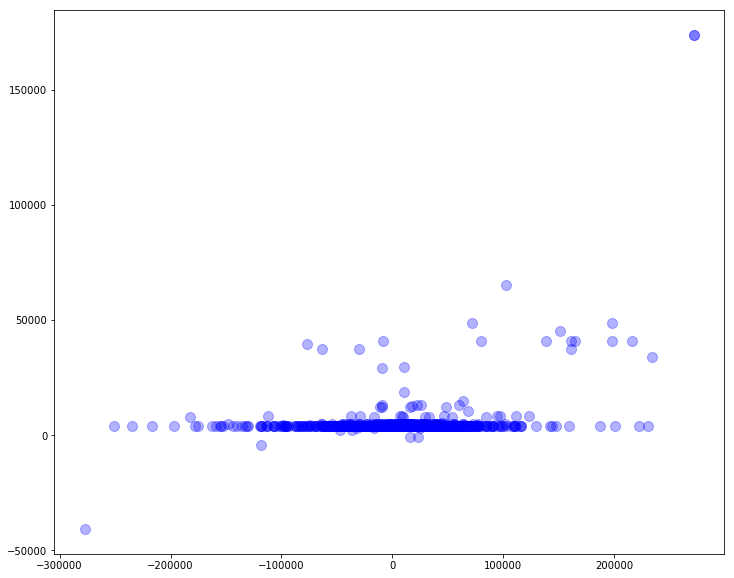

In [74]:
fig, ax = plt.subplots(figsize=(12,10))
ax.scatter(m1_errors, m2_preds, alpha=0.3, color="blue", s=100)

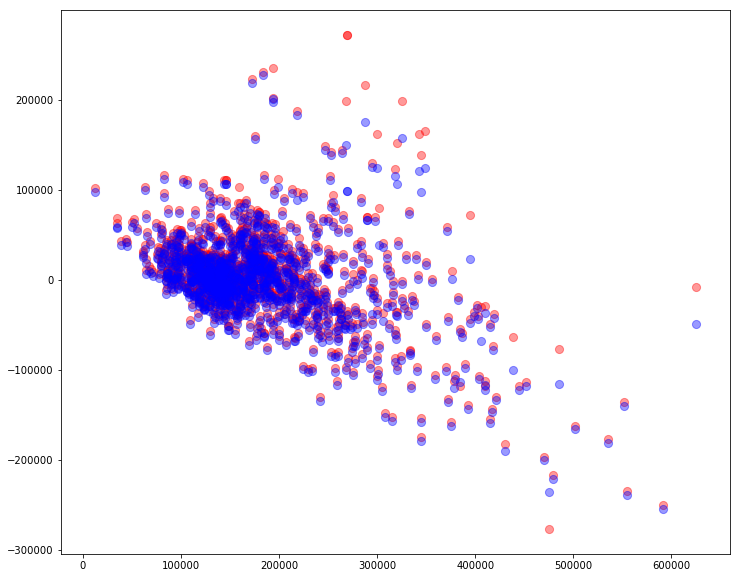

In [86]:
fig, bx = plt.subplots(figsize=(12,10))
bx.scatter(y_train2, m1_preds - y_train2, alpha=0.4, color="red", s=66)
bx.scatter(y_train2, (m1_preds - m2_preds) - y_train2, alpha=0.4, color="blue", s=66)

In [101]:
for x in range(10):
    print run_stacked_ensemble(simple_data, Y)

(47140.122574469344, 47364.956927541571)
(48629.587725197402, 49317.918880264668)
(47726.188913897873, 47958.772893058929)
(51896.21355861456, 52488.124564640813)
(48680.473417992522, 48728.07598392979)
(47130.341705223575, 44493.024942258206)
(53465.283285386584, 54527.003105589538)
(50738.57202127936, 51173.925571202672)
(48792.198100315043, 51050.839559559048)
(48019.361287711305, 48663.582736351367)


### ^ Seems to be working horribly

In [117]:
def run_sidecar_ensemble(X, y):
    '''
    Simply take the average prediction of several models and use that for a prediction
    
    Returns the RMSE resulting from that
    '''
    # split the data for train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
    
    m1 = SVR()
    m2 = RandomForestRegressor(n_estimators=1000, n_jobs=-1)
    m3 = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.001)
    m4 = LinearRegression(fit_intercept=True)
    m5 = DecisionTreeRegressor()
    
    models = [m1, m2, m3, m4, m5]
    
    preds = []
    for model in models:
        print "Fitting {}...".format(model.__class__.__name__)
        model.fit(X_train, y_train)
        
        print "Predicting {}...".format(model.__class__.__name__)
        model_pred = model.predict(X_test)
        
        preds.append(model_pred)
        
    average_pred = preds[0]
    
    if (len(models) - 1) > 0:
        for idx in range(len(models) - 1):

            for idy, pred in enumerate(preds[idx]):
                average_pred[idy] += pred

        average_pred = [pred / (len(models)*1.0) for pred in average_pred]

    # figure out RMSE of the average of the preds
    rmse = np.sqrt(mean_squared_error(average_pred, y_test))
    
    return rmse

In [119]:
results = np.zeros(50)
for x in range(50):
    results[x] = run_sidecar_ensemble(simple_data, Y)

Fitting SVR...
Predicting SVR...
Fitting RandomForestRegressor...
Predicting RandomForestRegressor...
Fitting GradientBoostingRegressor...
Predicting GradientBoostingRegressor...
Fitting LinearRegression...
Predicting LinearRegression...
Fitting DecisionTreeRegressor...
Predicting DecisionTreeRegressor...
Fitting SVR...
Predicting SVR...
Fitting RandomForestRegressor...
Predicting RandomForestRegressor...
Fitting GradientBoostingRegressor...
Predicting GradientBoostingRegressor...
Fitting LinearRegression...
Predicting LinearRegression...
Fitting DecisionTreeRegressor...
Predicting DecisionTreeRegressor...
Fitting SVR...
Predicting SVR...
Fitting RandomForestRegressor...
Predicting RandomForestRegressor...
Fitting GradientBoostingRegressor...
Predicting GradientBoostingRegressor...
Fitting LinearRegression...
Predicting LinearRegression...
Fitting DecisionTreeRegressor...
Predicting DecisionTreeRegressor...
Fitting SVR...
Predicting SVR...
Fitting RandomForestRegressor...
Predicting Ra

(array([ 1.,  0.,  3.,  0.,  2.,  1.,  3.,  4.,  2.,  1.,  1.,  2.,  1.,
         9.,  4.,  5.,  2.,  2.,  0.,  2.,  3.,  0.,  1.,  0.,  1.]),
 array([ 51593.04314776,  52184.64987885,  52776.25660994,  53367.86334103,
         53959.47007212,  54551.07680322,  55142.68353431,  55734.2902654 ,
         56325.89699649,  56917.50372758,  57509.11045867,  58100.71718977,
         58692.32392086,  59283.93065195,  59875.53738304,  60467.14411413,
         61058.75084522,  61650.35757632,  62241.96430741,  62833.5710385 ,
         63425.17776959,  64016.78450068,  64608.39123178,  65199.99796287,
         65791.60469396,  66383.21142505]),
 <a list of 25 Patch objects>)

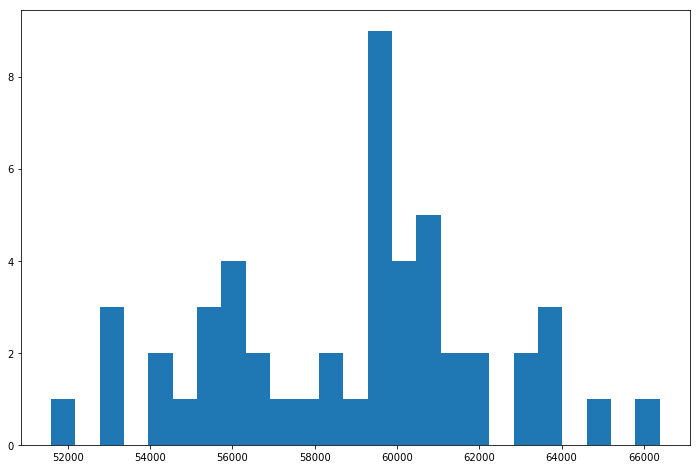

In [123]:
fig, cx = plt.subplots(figsize=(12,8))
cx.hist(results, bins=25)

In [187]:
def run_multi_stack(X, y):
    '''
    Simply take the average prediction of several models and use that for a prediction
    
    Returns the RMSE resulting from that
    '''
    # split the data for train and test
    X_train1, X_train2, X_test, y_train1, y_train2, y_test = make_data_splits(X, y)
    
    m1 = SVR(C=2.0)
    m2 = RandomForestRegressor(n_estimators=1000, n_jobs=-1)
    m3 = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.001)
    m4 = LinearRegression(fit_intercept=True)
    m5 = DecisionTreeRegressor()
    
    models = [m2, m3, m4, m5]
    
    preds = np.zeros((len(y_train2), len(models)))
    for idx, model in enumerate(models):
        print "Fitting {}...".format(model.__class__.__name__)
        model.fit(X_train1, y_train1)
        
        print "Predicting {}...".format(model.__class__.__name__)
        results = model.predict(X_train2).ravel()
        
        preds[:,idx] = results
        

    # figure out RMSE of the average of the preds
    rmses = []
    for x in range(len(models)):
        rmse = np.sqrt(mean_squared_error(preds[:,x], y_train2))
        rmses.append(rmse)
    
    print "\n\n"
    print "First stage RMSEs."
    print "{:<20} {:<20} {:<20} {:<20}".format("Random Forest", "Gradient Boosting", "Linear Regression", "Decision Tree")
    print "{:<20} {:<20} {:<20} {:<20}".format(rmses[0], rmses[1], rmses[2], rmses[3])
    print "\n\n"
    
    # second stage model that takes predictions from models trained on first whack of data
    blender = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.001)
    
    # fit blender
    blender.fit(preds, y_train2)
    
    # now take in the whole pipeline on the test set
    
    # first get predictions on test set from the stage 1 models
    final_s1_preds = np.zeros((len(y_test), len(models)))
    
    for idx, model in enumerate(models):
        print "Predicting Test data with {}...".format(model.__class__.__name__)
        results = model.predict(X_test).ravel()
        
        final_s1_preds[:,idx] = results
    
    final_preds = blender.predict(final_s1_preds)
    
    rmse = np.sqrt(mean_squared_error(final_preds, y_test))
    
    print "\nFinal RMSE:{:6.1f}".format(rmse)
    
    return rmse

In [188]:
outcomes = np.zeros((10,1))

for x in range(10):
    outcomes[x] = run_multi_stack(simple_data, Y)
    
print "\nMean RMSE of 10 Runs:{:6.1f}".format(outcomes.mean())

Fitting RandomForestRegressor...


/home/brian/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Predicting RandomForestRegressor...
Fitting GradientBoostingRegressor...
Predicting GradientBoostingRegressor...
Fitting LinearRegression...
Predicting LinearRegression...
Fitting DecisionTreeRegressor...
Predicting DecisionTreeRegressor...



First stage RMSEs.
Random Forest        Gradient Boosting    Linear Regression    Decision Tree       
47819.9374236        52000.2686472        53457.1085706        61884.7593452       



Predicting Test data with RandomForestRegressor...
Predicting Test data with GradientBoostingRegressor...
Predicting Test data with LinearRegression...
Predicting Test data with DecisionTreeRegressor...

Final RMSE:51554.5
Fitting RandomForestRegressor...
Predicting RandomForestRegressor...
Fitting GradientBoostingRegressor...
Predicting GradientBoostingRegressor...
Fitting LinearRegression...
Predicting LinearRegression...
Fitting DecisionTreeRegressor...
Predicting DecisionTreeRegressor...



First stage RMSEs.
Random Forest        Gradient Boosting    Linea